# 0. Importing libraries

In [181]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../Functions")
import warnings
warnings.filterwarnings(action = 'ignore')
import custom_functions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')
## Change title size of a plot
mpl.rcParams['axes.titlesize'] = 22
# Figure size
mpl.rc("figure", figsize = (15,7))
## Change label size(x and y) of a plot
mpl.rcParams['axes.labelsize'] = 18
## Change xticks size of a plot
mpl.rcParams['xtick.labelsize'] = 16
## Change yticks size of a plot
mpl.rcParams['ytick.labelsize'] = 16

# 1. Loading data

In [195]:
# loading csv file as a dataframe
data = pd.read_csv("DATA/bank-full.csv", sep = ";")

# 2. Data exploring

In [196]:
# Number of observations and variables
data.shape

(45211, 17)

In [197]:
# List of variables
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

## What variables represent?

### Bank Client Data

1 - age (**numeric**)

2 - job : type of job (**categorical**: "admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student",
                        "blue-collar", "self-employed", "retired", "technician", "services") 

3 - marital : marital status (**categorical**: "married", "divorced", "single"; note: "divorced" means divorced or widowed)

4 - education (**categorical**: "unknown", "secondary", "primary", "tertiary")

5 - default: has credit in default? (**binary**: "yes", "no")

6 - balance: average yearly balance, in euros (**numeric**) 

7 - housing: has housing loan? (**binary**: "yes", "no")

8 - loan: has personal loan? (**binary**: "yes", "no")

### Related with the last contact of the current campaign:

9 - contact: contact communication type (**categorical**: "unknown", "telephone", "cellular") 

10 - day: last contact day of the month (**numeric**)

11 - month: last contact month of year (**categorical**: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (**numeric**)

### other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (**numeric**, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (**numeric**, -1 means client
was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (**numeric**)

16 - poutcome: outcome of the previous marketing campaign (**categorical**: "unknown", "other", "failure", "success")

### Output variable (desired target):
17 - y - has the client subscribed a term deposit? (**binary**: "yes", "no")

In [45]:
# Information about the dataframe
# null_counts = true, will not count rows which have missing values in it.
data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [46]:
# Checking for missing values
data.isna().all()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

There are no missing values in any variables as mentioned by the data owner now I can carry out initial exploration using visualization after splitting data into 3 groups(training, validation and testing). 

### Some data preprocessing

In [219]:
# Dummy variables for nominal columns
dummy_cols = pd.get_dummies(data.loc[:, ['job', 'marital', 'education', 'month', 'poutcome']])

# Label encoding for binary variables
label_en = LabelEncoder()

# Empty dataframe
encoded_cols = pd.DataFrame()

# Adding encoded columns
encoded_cols['default_code'] = label_en.fit_transform(data['default'])
encoded_cols['loan_code'] = label_en.fit_transform(data['loan'])
encoded_cols['housing_code'] = label_en.fit_transform(data['housing'])
encoded_cols['y_code'] = label_en.fit_transform(data['y'])

# Creating new dataframe
data_new = data.copy()
data_new = data_new.join(dummy_cols)
data_new = data_new.join(encoded_cols)

### Splitting the data

In [220]:
shuffled_data = shuffle(data_new, random_state = 73).reset_index(drop = True)

# Splitting the dataframe in train, validate and test
## Reference - https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.split.html
train_df, validate_df, test_df = np.split(
                                          shuffled_data.sample(frac = 1), 
                                          [ int( 0.8 * len(shuffled_data) ), int( 0.9 * len(shuffled_data) ) ] 
                                         )

### Storing the data in .CSV files

In [221]:
train_df.to_csv("DATA/train.csv", sep = "\t", index = False)
validate_df.to_csv("DATA/validate.csv", sep = "\t", index = False)
test_df.to_csv("DATA/test.csv", sep = "\t", index = False)

### Loading the data

In [222]:
train_df = pd.read_csv("DATA/train.csv", sep = "\t")
validate_df = pd.read_csv("DATA/validate.csv", sep = "\t")
test_df = pd.read_csv("DATA/test.csv", sep = "\t")

In [223]:
print("Training dataset :", train_df.shape)
print("Validation dataset :", validate_df.shape)
print("Testing dataset :", test_df.shape)

Training dataset : (36168, 56)
Validation dataset : (4521, 56)
Testing dataset : (4522, 56)


## Data Summaries and Visualizations

### age

In [224]:
train_df["age"].describe()

count    36168.000000
mean        40.953688
std         10.631392
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

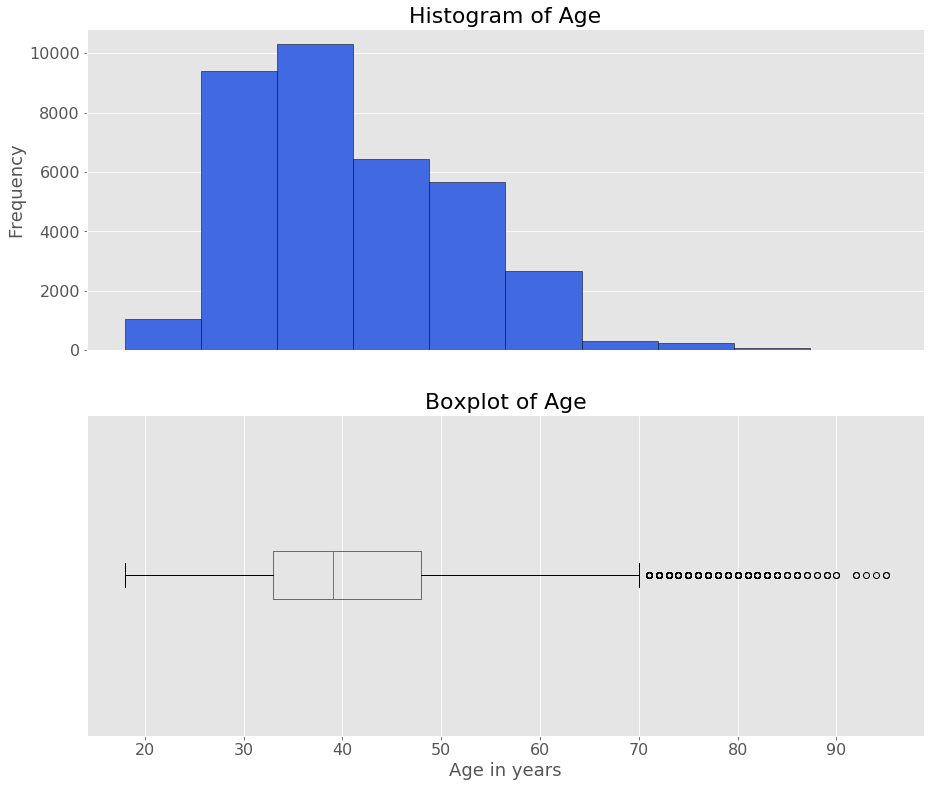

In [225]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["age"], "Age", color = "royalblue", ylabel = "Frequency", 
                                               xlabel = "Age in years" , size = (15,13))

In [227]:
print("Number of outliers :", train_df[train_df["age"] > 70].shape[0])

Number of outliers : 387


Distribution is right skewed which makes sense as there should be less participation from old people in such term deposit plan that's why there are outliers in the data. Observations where age is greater than 70 years(BY looking at the boxplot right hand whisker) are outliers, which is reasonable amount.

### job

In [228]:
# Frequency
job_count_series = train_df["job"].value_counts()
job_count_series

blue-collar      7744
management       7573
technician       6130
admin.           4153
services         3296
retired          1828
self-employed    1248
entrepreneur     1206
unemployed       1046
housemaid         974
student           741
unknown           229
Name: job, dtype: int64

In [229]:
# Percentage
job_count_series/train_df.shape[0] * 100

blue-collar      21.411192
management       20.938399
technician       16.948684
admin.           11.482526
services          9.113028
retired           5.054192
self-employed     3.450564
entrepreneur      3.334439
unemployed        2.892059
housemaid         2.692988
student           2.048772
unknown           0.633156
Name: job, dtype: float64

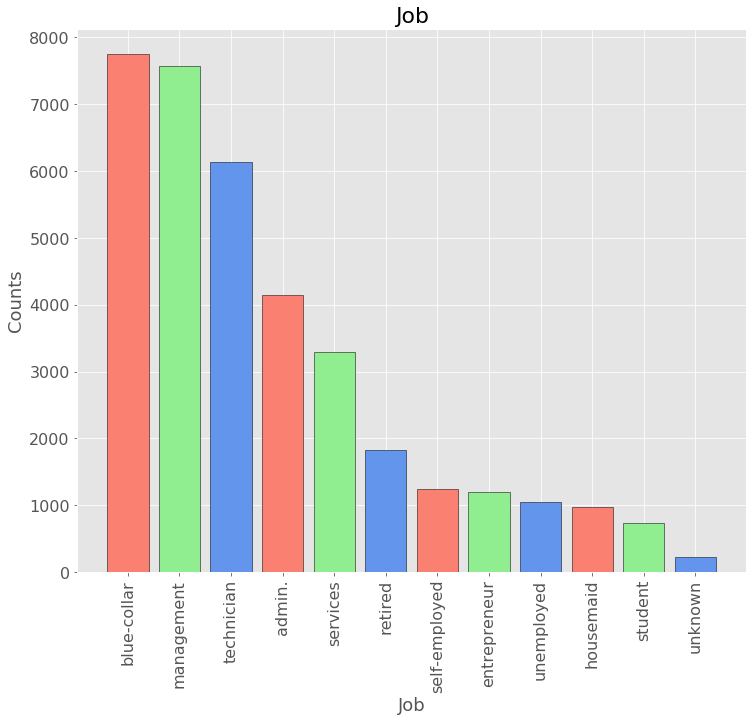

In [230]:
# Barplot
%autoreload 2
custom_functions.barplot(job_count_series, "Job", "Counts", "Job", 
                         color = ("salmon", "lightgreen", "cornflowerblue",) * 4, labels = job_count_series.index, 
                         xrotation = 90)

Most of the customers have blue-collar jobs or jobs in management. Very few Housemaid and stundents have bank accounts.

### marital

In [231]:
# Frequency
marital_count_series = train_df["marital"].value_counts()
marital_count_series

married     21737
single      10253
divorced     4178
Name: marital, dtype: int64

In [232]:
# Percentage
marital_count_series/train_df.shape[0] * 100

married     60.100088
single      28.348264
divorced    11.551648
Name: marital, dtype: float64

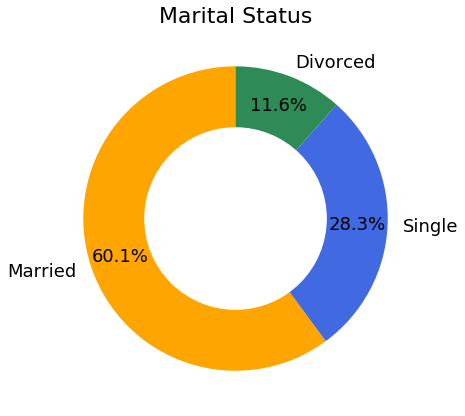

In [233]:
# Donut Chart
plt.pie(marital_count_series, colors = ["orange", "royalblue", "seagreen"], labels = ["Married", "Single", "Divorced"], 
        autopct = '%1.1f%%', startangle = 90, pctdistance = 0.80, textprops = {"fontsize" : 18})
plt.gca().add_artist(plt.Circle((0, 0), 0.60, fc = 'white'));
plt.title("Marital Status")
plt.show()

Most of the account holders are married.

### education

In [234]:
# Frequency
edu_count_series = train_df["education"].value_counts()
edu_count_series

secondary    18586
tertiary     10641
primary       5469
unknown       1472
Name: education, dtype: int64

In [235]:
# Percentage
edu_count_series/train_df.shape[0] * 100

secondary    51.387967
tertiary     29.421035
primary      15.121102
unknown       4.069896
Name: education, dtype: float64

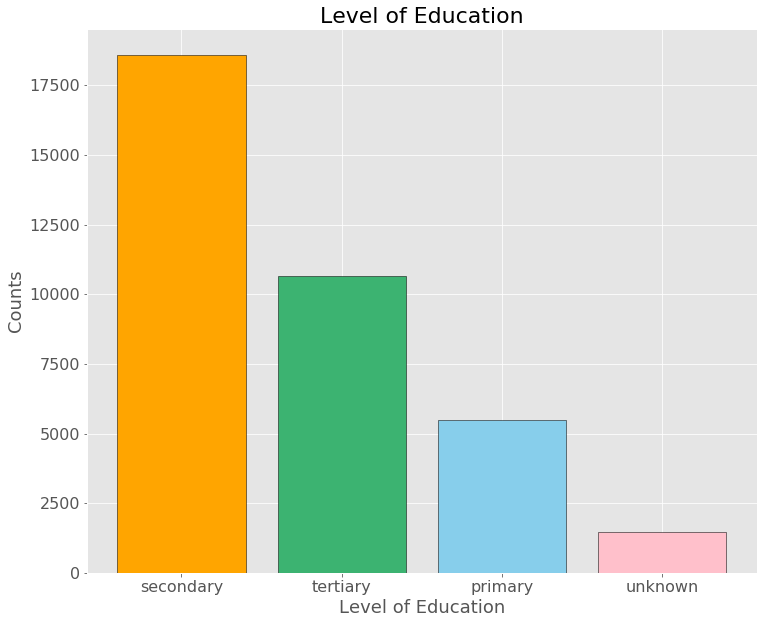

In [236]:
# Barplot
%autoreload 2
custom_functions.barplot(edu_count_series, "Level of Education", "Counts", "Level of Education", 
                         color = ("orange", "mediumseagreen", "skyblue", "pink"), labels = edu_count_series.index)

Most of the account holders have secondary educations followed by customers who have tertiary education.

### default

In [237]:
# Frequency
default_count_series = train_df["default"].value_counts()
default_count_series

no     35506
yes      662
Name: default, dtype: int64

In [238]:
# Percentage
default_count_series/train_df.shape[0] * 100

no     98.169653
yes     1.830347
Name: default, dtype: float64

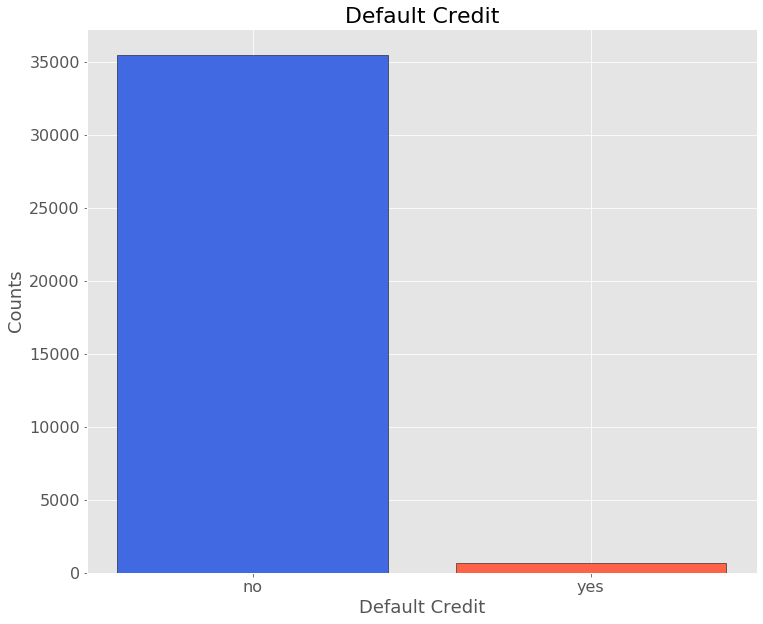

In [239]:
# Barplot
%autoreload 2
custom_functions.barplot(default_count_series, "Default Credit", "Counts", "Default Credit", color = ("royalblue", "tomato"), 
                         labels = default_count_series.index)

Nearly 1.8% of the account holders were failed to repay a debt back to the bank.

### balance

In [242]:
train_df["balance"].describe()

count     36168.000000
mean       1362.849010
std        3073.244024
min       -6847.000000
25%          71.000000
50%         446.000000
75%        1421.250000
max      102127.000000
Name: balance, dtype: float64

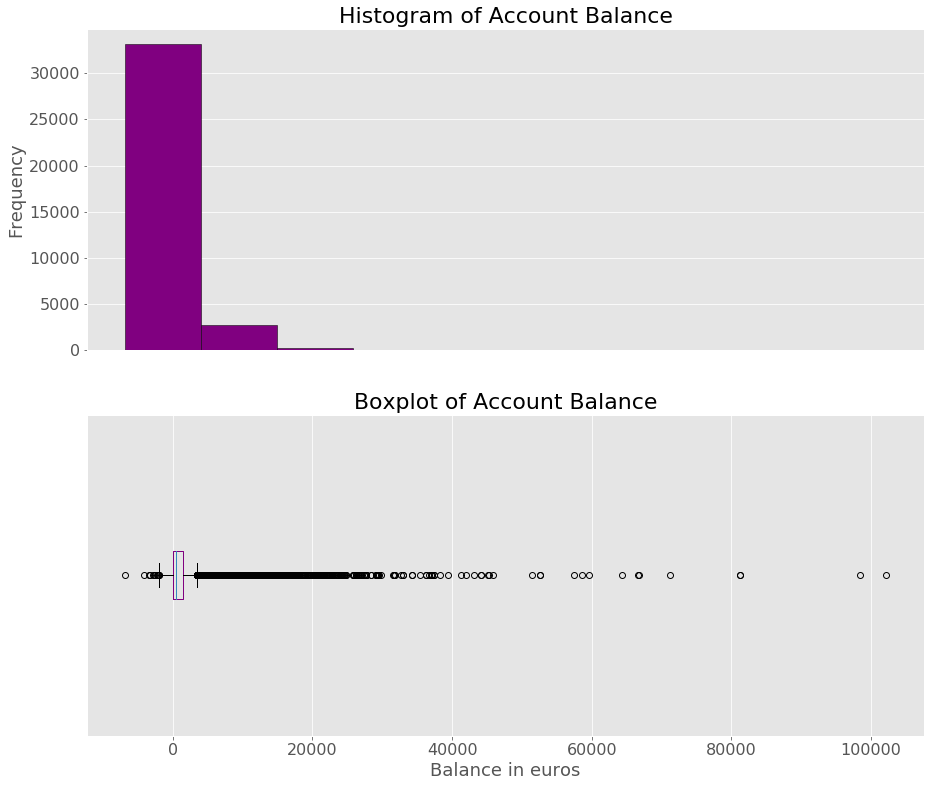

In [243]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["balance"], "Account Balance", color = "purple", 
                                               ylabel = "Frequency", xlabel = "Balance in euros" , size = (15, 13))

As we can see there are many outliers in the balance variable, by looking at the boxplot above we can say that amount greater than 40k can be ruled as extreme. Let's have a look at those account holders.

In [255]:
train_df[train_df["balance"] > 40000].iloc[:,:17]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
513,61,self-employed,divorced,tertiary,no,52587,no,no,cellular,10,aug,290,1,-1,0,unknown,yes
524,50,services,married,secondary,no,57435,yes,no,cellular,21,nov,319,3,-1,0,unknown,no
4584,38,admin.,single,tertiary,no,45789,no,no,telephone,21,jul,21,31,-1,0,unknown,no
10340,42,entrepreneur,married,tertiary,no,42045,no,no,cellular,8,aug,205,2,-1,0,unknown,no
12032,59,retired,married,tertiary,no,41242,no,no,cellular,21,nov,161,1,-1,0,unknown,no
14594,60,retired,married,primary,no,71188,no,no,cellular,6,oct,205,1,-1,0,unknown,no
14789,59,admin.,married,unknown,no,64343,no,no,cellular,6,aug,45,4,-1,0,unknown,no
15934,84,retired,married,secondary,no,81204,no,no,telephone,1,apr,390,1,94,3,success,yes
16387,44,admin.,married,secondary,no,58544,yes,no,unknown,7,may,144,2,-1,0,unknown,no
16965,61,self-employed,divorced,tertiary,no,52587,no,no,cellular,15,feb,394,3,189,1,success,yes


There are many outliers in account balance variable. Most extremes(approx. 20) outliers are where the account balance is greater than 40,000 EUROS. All other columns seem valid so I will keep the outliers as they are because they represent the nature of the distribution. Most of the high balance account holders are in management jobs or retired and had tertiary education. Most of the account holders are married as well as they dont have default credit(given high balance). Most of them have neither have personal or home loan(given high balance). 

In [257]:
negative_bal = train_df[train_df["balance"] < 0].copy()
negative_bal.iloc[:,:17].head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,37,blue-collar,married,secondary,no,-57,yes,yes,cellular,7,may,55,5,-1,0,unknown,no
16,45,blue-collar,divorced,primary,no,-207,no,no,cellular,15,jul,878,2,-1,0,unknown,yes
41,51,technician,married,secondary,no,-1042,yes,no,unknown,27,may,272,2,-1,0,unknown,no
46,31,unemployed,single,secondary,no,-15,yes,no,cellular,12,may,278,2,370,3,other,no
50,41,blue-collar,married,primary,no,-45,yes,yes,unknown,9,may,121,4,-1,0,unknown,no
75,54,admin.,divorced,secondary,no,-288,yes,no,unknown,27,may,138,2,-1,0,unknown,no
76,43,management,divorced,tertiary,no,-173,no,yes,cellular,18,aug,119,7,-1,0,unknown,no
89,29,technician,single,secondary,yes,-397,yes,no,unknown,28,may,114,1,-1,0,unknown,no
93,27,admin.,married,secondary,no,-247,yes,yes,unknown,4,jun,344,2,-1,0,unknown,no
156,29,management,single,tertiary,no,-233,yes,no,unknown,19,may,329,1,-1,0,unknown,no


In [246]:
## AGE
negative_bal["age"].describe()

count    3029.000000
mean       39.491251
std         9.062039
min        20.000000
25%        32.000000
50%        38.000000
75%        46.000000
max        63.000000
Name: age, dtype: float64

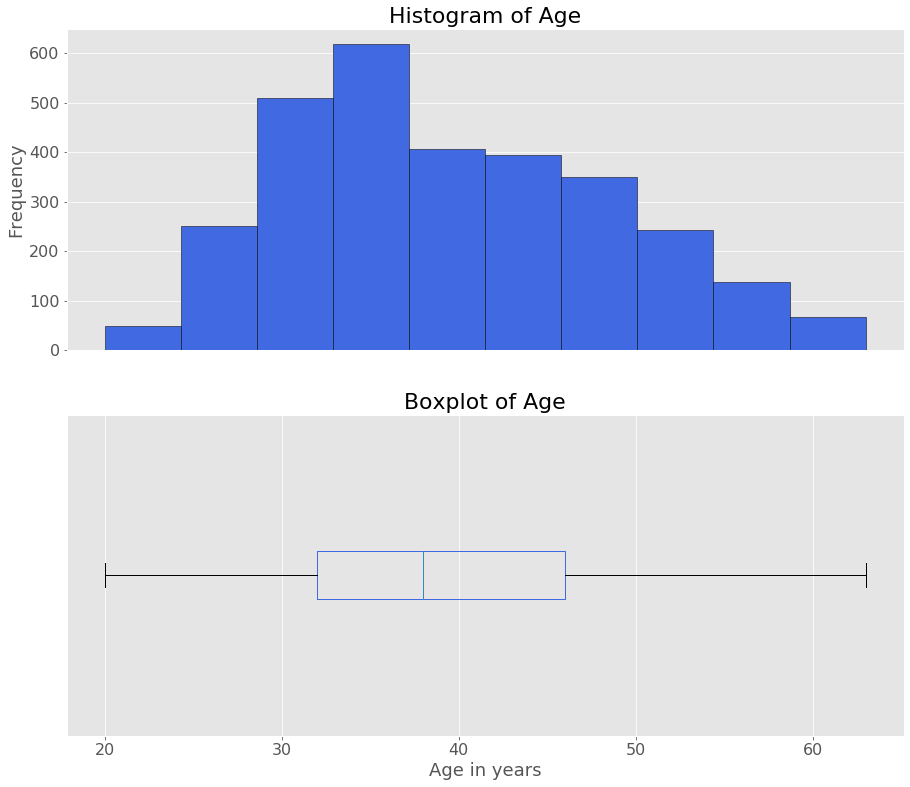

In [247]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(negative_bal["age"], "Age", color = "royalblue", ylabel = "Frequency", 
                                               xlabel = "Age in years" , size = (15,13))

Most of the account holders with the negative balance are aged between 32 and 46\[Working adults\]. 

In [264]:
negative_bal["job"].value_counts()/len(negative_bal) * 100

blue-collar      29.547706
technician       17.332453
management       15.351601
admin.           13.139650
services         12.974579
retired           3.070320
entrepreneur      3.070320
self-employed     2.377022
unemployed        1.782767
housemaid         0.924397
student           0.297128
unknown           0.132057
Name: job, dtype: float64

As we can see that most of the account holders(more than 25%) have blue collar job, which explains the negative balance as these people work at the bottom of the chain and enagaged with manual labor work. 

In [265]:
negative_bal["education"].value_counts()/len(negative_bal) * 100

secondary    61.538462
tertiary     19.346319
primary      15.879828
unknown       3.235391
Name: education, dtype: float64

compare to people with account having high balance, most of these account holders have fininshed secondary education(high school), which also explain the fact that they are engaged in the manual labour work and not high end job like management.

In [279]:
print("Neg balance Housing Loan : \n")
print(negative_bal["housing"].value_counts()/len(negative_bal) * 100)

Neg balance Housing Loan : 

yes    72.796302
no     27.203698
Name: housing, dtype: float64


By looking at the data, as we can see that most of the people with negative balance have housing loan.

### housing

In [143]:
# Frequency
housing_count_series = train_df["housing"].value_counts()
housing_count_series

yes    20131
no     16037
Name: housing, dtype: int64

In [144]:
# Percentage
housing_count_series/train_df.shape[0] * 100

yes    55.659699
no     44.340301
Name: housing, dtype: float64

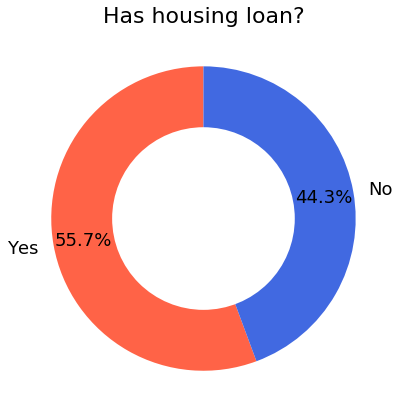

In [145]:
# Donut Chart
plt.pie(housing_count_series, colors = ["tomato", "royalblue"], labels = ["Yes", "No"], 
        autopct = '%1.1f%%', startangle = 90, pctdistance = 0.80, textprops = {"fontsize" : 18})
plt.gca().add_artist(plt.Circle((0, 0), 0.60, fc = 'white'));
plt.title("Has housing loan?")
plt.show()

Majority of the customers have a housing loan.

### loan

In [146]:
# Frequency
loan_count_series = train_df["loan"].value_counts()
loan_count_series

no     30342
yes     5826
Name: loan, dtype: int64

In [147]:
# Percentage
loan_count_series/train_df.shape[0] * 100

no     83.891838
yes    16.108162
Name: loan, dtype: float64

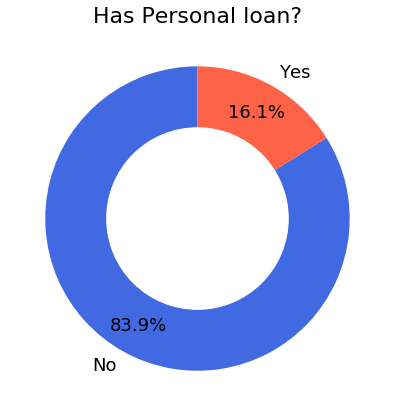

In [148]:
# Donut Chart
plt.pie(loan_count_series, colors = ["royalblue", "tomato"], labels = ["No", "Yes"], 
        autopct = '%1.1f%%', startangle = 90, pctdistance = 0.80, textprops = {"fontsize" : 18})
plt.gca().add_artist(plt.Circle((0, 0), 0.60, fc = 'white'));
plt.title("Has Personal loan?")
plt.show()

Majority of the account holders does not have a personal loan.

### contact

In [149]:
# Frequency
contact_count_series = train_df["contact"].value_counts()
contact_count_series

cellular     23473
unknown      10405
telephone     2290
Name: contact, dtype: int64

In [150]:
# Percentage
contact_count_series/train_df.shape[0] * 100

cellular     64.899912
unknown      28.768525
telephone     6.331564
Name: contact, dtype: float64

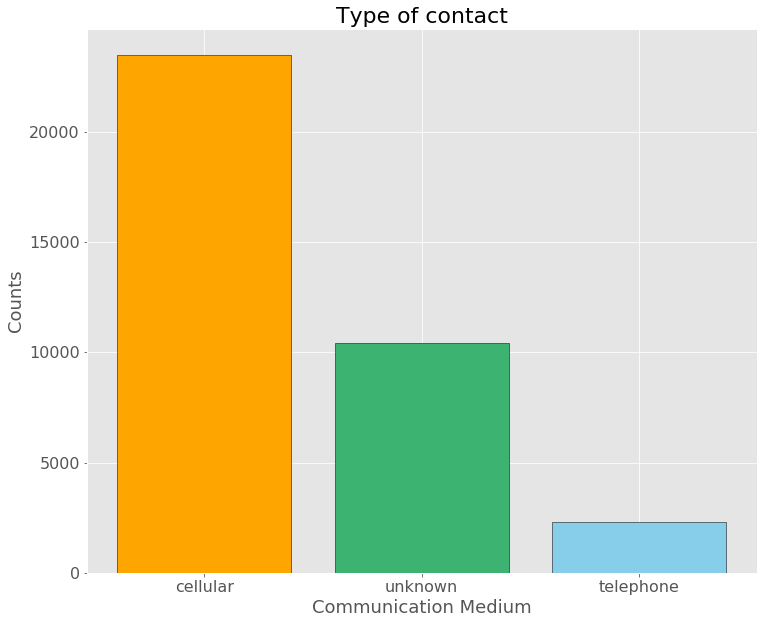

In [151]:
# Barplot
%autoreload 2
custom_functions.barplot(contact_count_series, "Communication Medium", "Counts", "Type of contact", 
                         color = ("orange", "mediumseagreen", "skyblue"), labels = contact_count_series.index)

Most of the customers were contacted on their cellular regarding the term deposit which makes sense as time when data was collected mobile phones were more prominient and everyone had one with them. 

In [152]:
print("Median age of the customers who were contacted using cellular :", 
      train_df[train_df["contact"] == "cellular"]["age"].median())

Median age of the customers who were contacted using cellular : 38.0


In [153]:
print("Median age of the customers who were contacted using telephone :", 
      train_df[train_df["contact"] == "telephone"]["age"].median())

Median age of the customers who were contacted using telephone : 47.0


The above calculation and graphs reflect that cellular was more popular among the younger people compared to people using telephone. \[Old People generally use telephones\]

### day

In [154]:
# Frequency
day_count_series = train_df["day"].value_counts()
day_count_series

20    2194
18    1872
21    1617
17    1553
6     1540
5     1525
8     1487
14    1477
7     1465
28    1453
19    1409
29    1387
15    1357
12    1290
13    1287
9     1256
30    1214
11    1175
4     1160
16    1132
2     1018
27     891
3      865
26     857
23     750
22     733
25     661
31     514
10     414
24     362
1      253
Name: day, dtype: int64

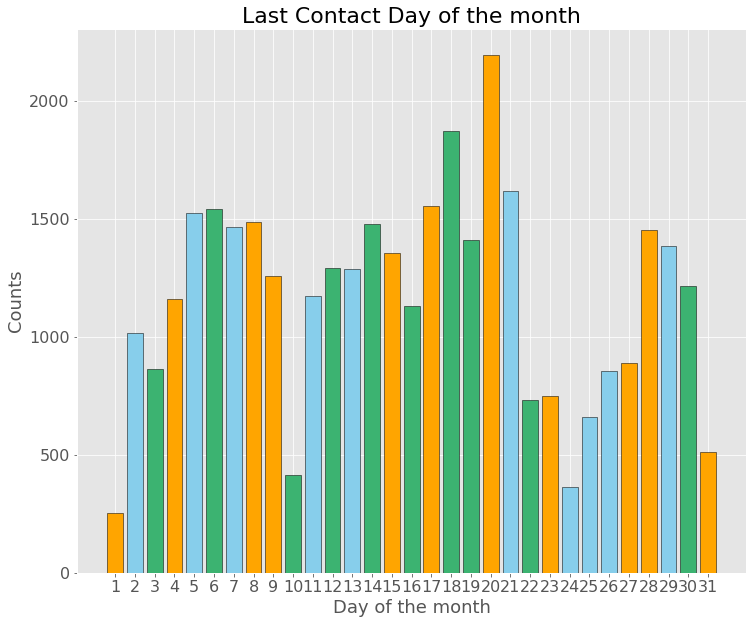

In [155]:
# Barplot
%autoreload 2
custom_functions.barplot(day_count_series, "Day of the month", "Counts", "Last Contact Day of the month", 
                         color = ("orange", "mediumseagreen", "skyblue",) * 10, labels = day_count_series.index)

Contacts regarding the term deposits were generally made in the middle of the months The Least mean amount of the calls were made in the last week of the months.

### month

In [156]:
# Frequency
month_count_series = train_df["month"].value_counts()
print(month_count_series)
month_count_series = month_count_series[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct','nov', 'dec']]

may    11071
jul     5529
aug     4955
jun     4238
nov     3208
apr     2341
feb     2081
jan     1125
oct      588
sep      468
mar      391
dec      173
Name: month, dtype: int64


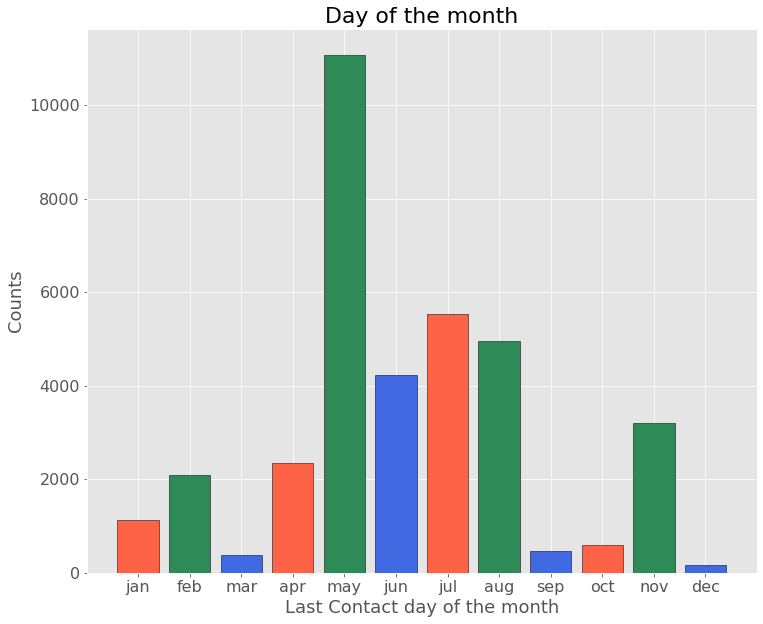

In [157]:
# Barplot
%autoreload 2
custom_functions.barplot(month_count_series, "Last Contact day of the month", "Counts", "Day of the month", 
                         color = ("tomato", "seagreen", "royalblue",) * 10, labels = month_count_series.index)

Most of the contacts were made in the month may. Majority of the contacts were made in the middle of the year. December has the least number of the contacts that can be explained by the festive season(employees not working/customers don't have time to talk to the bank employees/last month of the fiscal year)

### duration

In [158]:
train_df["duration"].describe()

count    36168.000000
mean       257.960683
std        255.923726
min          0.000000
25%        103.000000
50%        180.000000
75%        318.000000
max       3785.000000
Name: duration, dtype: float64

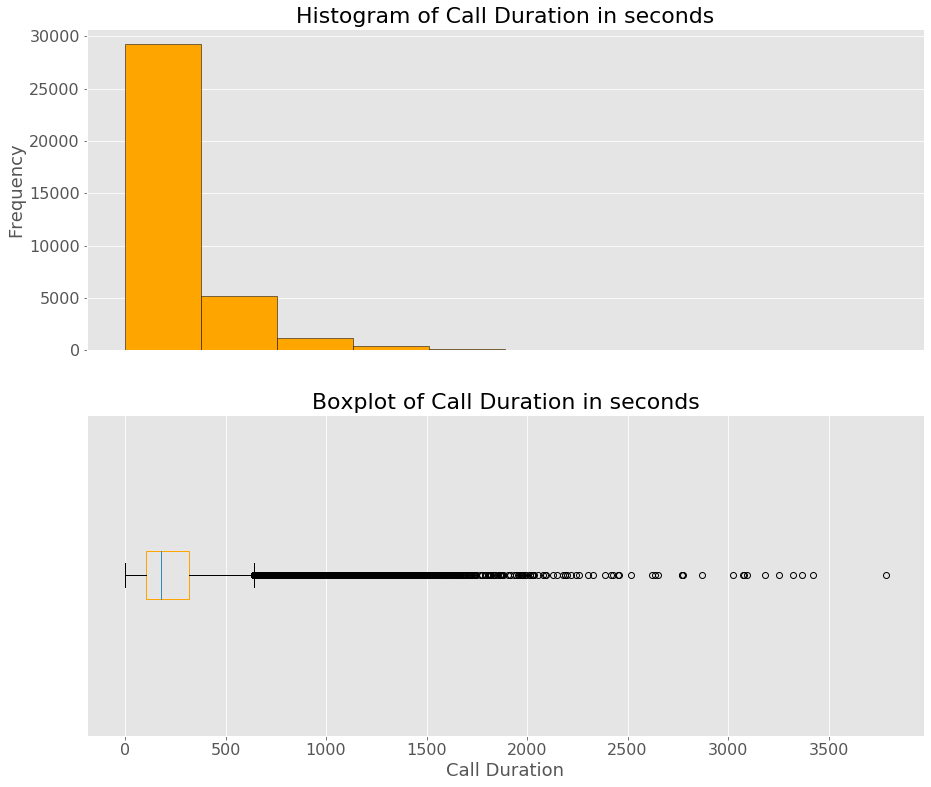

In [159]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["duration"], "Call Duration in seconds", color = "orange", 
                                               ylabel = "Frequency", xlabel = "Call Duration" , size = (15, 13))

Most common duration for the call is 3 minutes(180 seconds). There are many outliers out of which duration > 2500 seconds are extreme ones. Maximum duration for the call is 63 minutes(3785 seconds) which is quite long.

### campaign

In [160]:
train_df["campaign"].describe()

count    36168.000000
mean         2.762663
std          3.091166
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

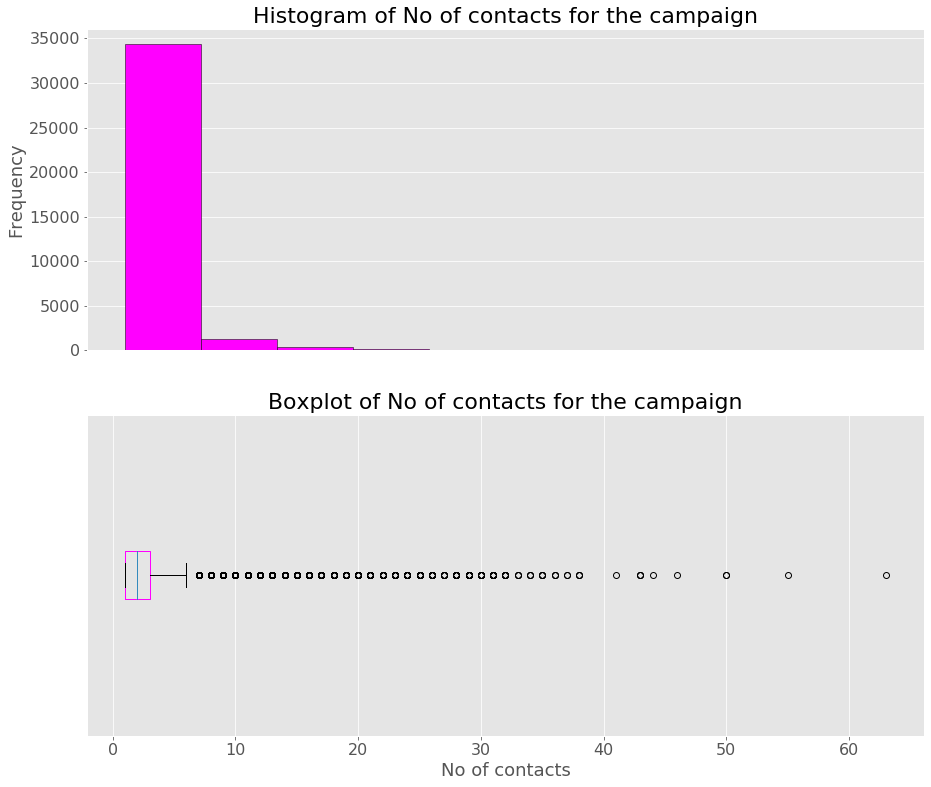

In [161]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["campaign"], "No of contacts for the campaign", color = "magenta", 
                                               ylabel = "Frequency", xlabel = "No of contacts" , size = (15, 13))

On average account holders were contacted 2 times. There aremany outliers out of which no of the times contacts are greater 40 are extreme. The highest no of contact is 63 which is quite large and unusual.

### pdays

In [162]:
not_contacted_count = train_df[train_df["pdays"] == -1].shape[0]
contacted_count = train_df.shape[0] - not_contacted_count

contacted = train_df[train_df["pdays"] != -1]

print("Previously Contacted :", contacted_count)
print("Previously Not Contacted :", not_contacted_count)

Previously Contacted : 6601
Previously Not Contacted : 29567


In [163]:
contacted["pdays"].describe()

count    6601.000000
mean      225.221633
std       115.516492
min         1.000000
25%       134.000000
50%       195.000000
75%       328.000000
max       871.000000
Name: pdays, dtype: float64

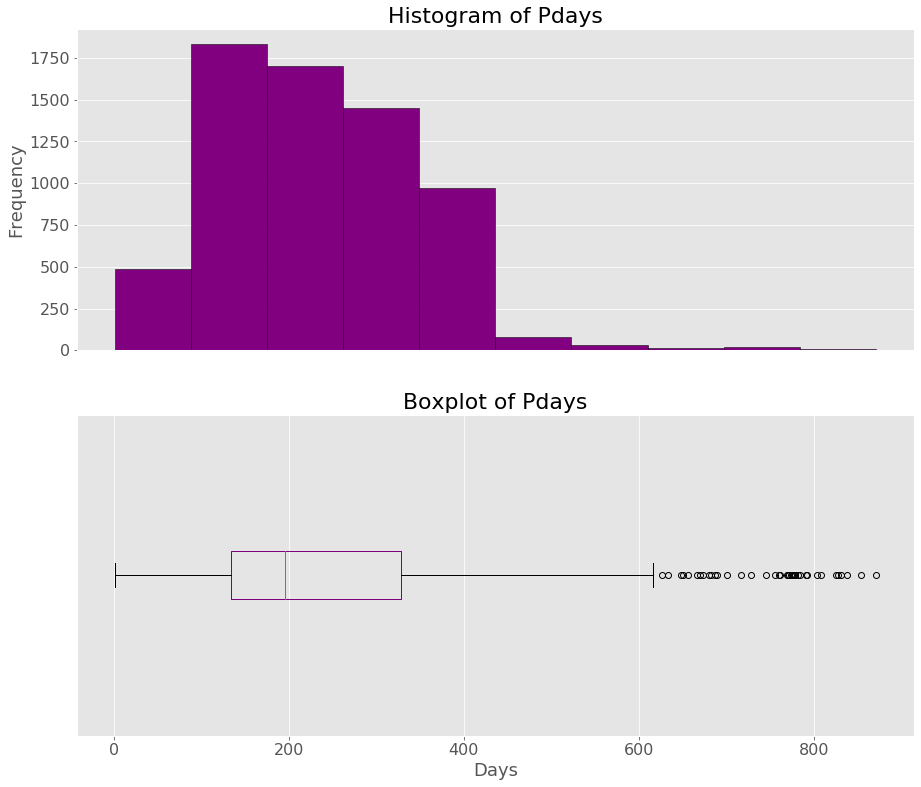

In [164]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(contacted["pdays"], "Pdays", color = "purple", 
                                               ylabel = "Frequency", xlabel = "Days" , size = (15, 13))

Average number of days that passed by after the client was last contacted from a previous campaign is 225 days. There are few outliers but none of them are too extreme.

In [165]:
train_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

### previous

In [166]:
train_df["previous"].describe()

count    36168.000000
mean         0.581094
std          2.394165
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

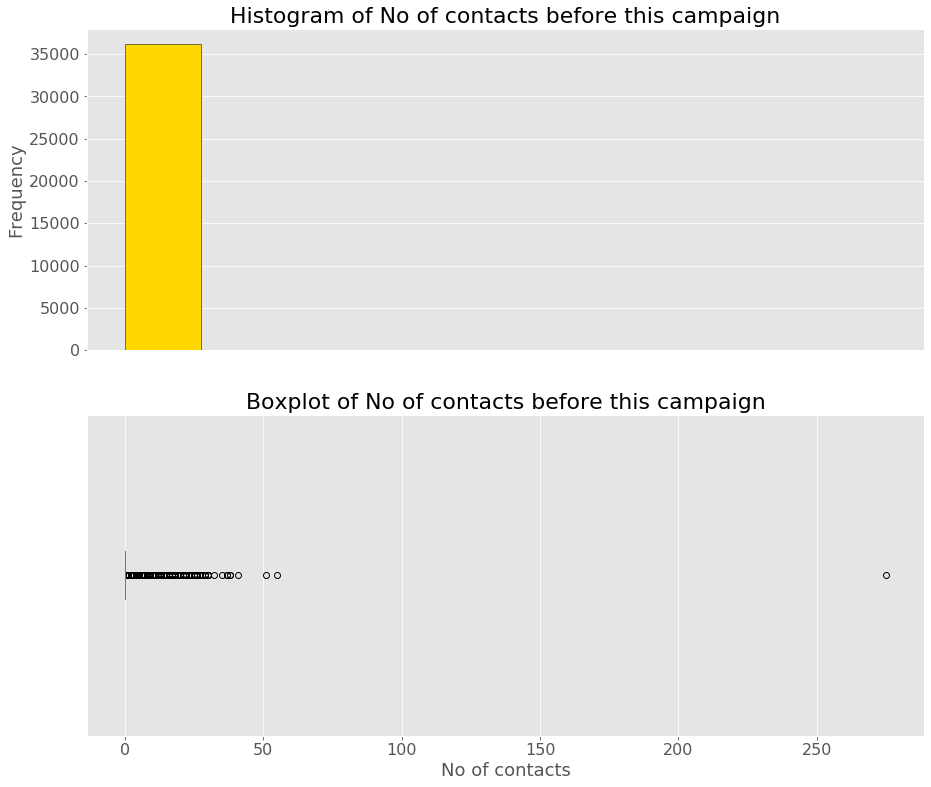

In [167]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["previous"], "No of contacts before this campaign", color = "gold", 
                                               ylabel = "Frequency", xlabel = "No of contacts" , size = (15, 13))

There is one extreme outlier where number of contacts performed before this campaign is 275. I will remove this observation from the data.

In [168]:
train_df = train_df[train_df["previous"] < 275]

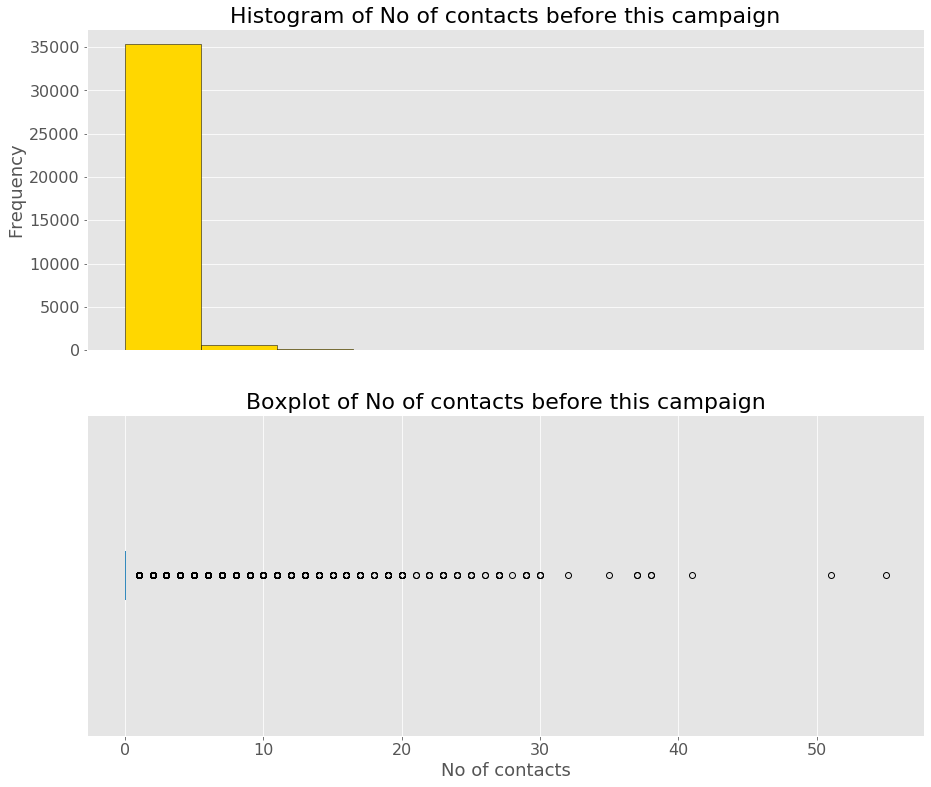

In [169]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["previous"], "No of contacts before this campaign", color = "gold", 
                                               ylabel = "Frequency", xlabel = "No of contacts" , size = (15, 13))

In [170]:
not_contacted_count = train_df[train_df["previous"] == 0].shape[0]
contacted_count = train_df.shape[0] - not_contacted_count

contacted = train_df[train_df["previous"] != 0]

print("Previously Contacted :", contacted_count)
print("Previously Not Contacted :", not_contacted_count)

Previously Contacted : 6600
Previously Not Contacted : 29567


In [171]:
contacted["previous"].describe()

count    6600.000000
mean        3.142727
std         3.453665
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        55.000000
Name: previous, dtype: float64

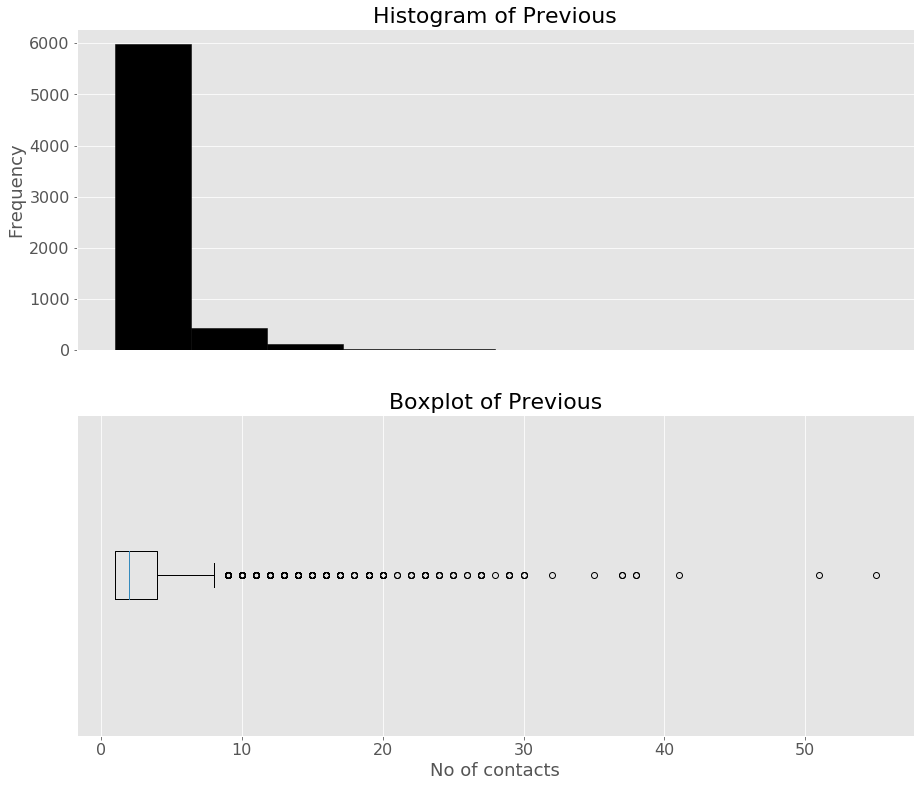

In [172]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(contacted["previous"], "Previous", color = "black", 
                                               ylabel = "Frequency", xlabel = "No of contacts" , size = (15, 13))

Average number of contacts made before this campaign is 3. There are few outliers few extreme ones where no of contact is greater than 50 but due to low in number I will keep them as it is.

### poutcome

In [173]:
# Frequency
poutcome_count_series = train_df["poutcome"].value_counts()
poutcome_count_series

unknown    29572
failure     3936
other       1464
success     1195
Name: poutcome, dtype: int64

In [174]:
# Percentage
poutcome_count_series/train_df.shape[0] * 100

unknown    81.765145
failure    10.882849
other       4.047889
success     3.304117
Name: poutcome, dtype: float64

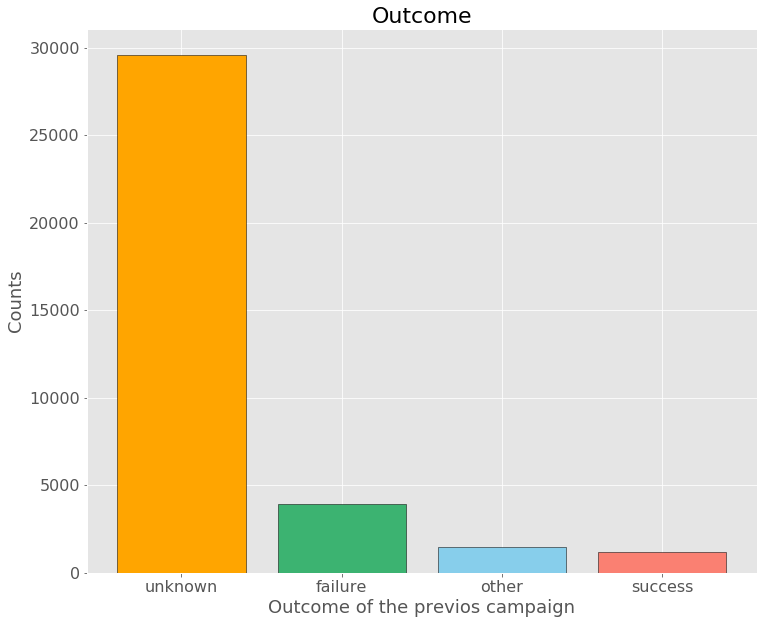

In [175]:
# Barplot
%autoreload 2
custom_functions.barplot(poutcome_count_series, "Outcome of the previos campaign", "Counts", "Outcome", 
                         color = ("orange", "mediumseagreen", "skyblue", "salmon"), labels = poutcome_count_series.index)

If we ignore the the observation where outcome is unknown and other, the success rate for the previous campaign is quite low(half as failure rate).

### y

In [176]:
# Frequency
y_count_series = train_df["y"].value_counts()
y_count_series

no     31972
yes     4195
Name: y, dtype: int64

In [177]:
# Percentage
y_count_series/train_df.shape[0] * 100

no     88.401029
yes    11.598971
Name: y, dtype: float64

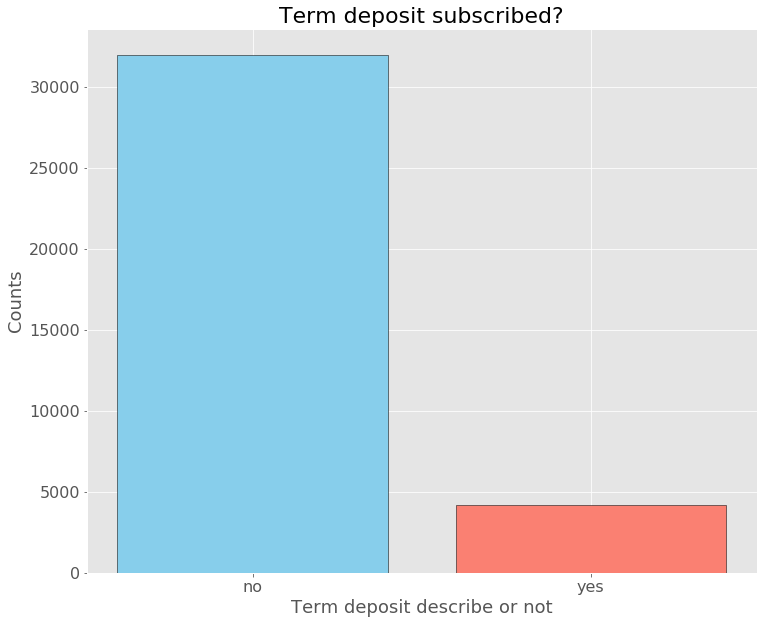

In [178]:
# Barplot
%autoreload 2
custom_functions.barplot(y_count_series, "Term deposit describe or not", "Counts", "Term deposit subscribed?", 
                         color = ("skyblue", "salmon"), labels = y_count_series.index)

There are only 12% of the clients subscribed to the terms which can be explained by the poor success rate of previous campaign outcome. As we can see that data is imbalanced in the terms of outcome variable.

## Data Preprocessing

In [191]:
smt = SMOTE()

X_train, y_train = smt.fit_sample(train_df.iloc[:, :-1], train_df["y"])

TypeError: check_array() got an unexpected keyword argument 'warn_on_dtype'

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,33,management,married,tertiary,no,1071,no,no,cellular,12,aug,83,4,-1,0,unknown
1,31,technician,married,secondary,no,5467,yes,no,cellular,13,apr,251,1,-1,0,unknown
2,33,management,married,tertiary,no,0,no,yes,cellular,21,aug,148,3,-1,0,unknown
3,36,management,married,tertiary,no,61,no,yes,cellular,19,aug,452,2,-1,0,unknown
4,38,unknown,married,unknown,no,124,yes,no,unknown,20,may,37,13,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,43,technician,single,tertiary,no,16,yes,no,unknown,12,may,282,4,-1,0,unknown
36164,37,management,single,tertiary,no,-533,no,no,cellular,26,aug,234,4,-1,0,unknown
36165,45,management,married,tertiary,no,1300,no,no,cellular,30,jul,135,3,-1,0,unknown
36166,41,management,married,tertiary,no,9935,no,no,telephone,21,nov,49,1,-1,0,unknown


## Modelling